In [63]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
import warnings
import sys
import sklearn
from tqdm import tqdm
import itertools
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import ADASYN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from pathlib import Path
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import ExtraTreesClassifier

warnings.filterwarnings('ignore')

In [65]:
df1 = pd.read_csv('/content/model_chk (1).csv',index_col = 0)

In [66]:
df1.columns

Index(['결혼여부', '신용카드소지여부', '주택대출여부', '개인대출여부', 'contact', '연락시도횟수', '과거통화횟수',
       '계약여부', '카드종류', '연락달', '연락요일', '연회비납부정도', '대학교구분', '직업급여별', '연령대_재범주화',
       '통화시간(분)', 'Target'],
      dtype='object')

In [68]:
df1['연령대_재범주화'].unique()

array(['Old-X세대', '산업화', '영포티', 'MZ세대', '베이비붐'], dtype=object)

In [72]:
df_oldx = df1[df1['연령대_재범주화'] == 'Old-X세대']
df_mz = df1[df1['연령대_재범주화'] == 'MZ세대']
df_y4 = df1[df1['연령대_재범주화'] == '영포티']
df_babyboom = df1[df1['연령대_재범주화'] == '베이비붐']
df_industry = df1[df1['연령대_재범주화'] == '산업화']

In [171]:
# df1 = df_mz.copy()
df1 = df_babyboom.copy()

In [172]:
X = df1.drop(['Target','계약여부'],axis = 1)
Y = df1['Target']

In [173]:
X_train, X_test, Y_train, Y_test =train_test_split(X,Y, random_state=1234)

In [174]:
# Separate Numeric and Categorical 
numeric_list  = X.describe().columns.tolist()
category_list = X.describe(include='object').columns.tolist()

In [175]:
# Numeric Data
numeric_pipe  = make_pipeline( SimpleImputer(strategy='median'), 
                              MinMaxScaler() )
# Categorical Data
category_pipe = make_pipeline( SimpleImputer(strategy='most_frequent'),
                               OneHotEncoder(handle_unknown='ignore') )

In [ ]:
# Other Option
# from imblearn.pipeline import Pipeline, make_pipeline
# model = Pipeline( [ ('scaler', MinMaxScaler()),
#                    ('model', ExtraTreesClassifier() ) ] )
# model.fit(train_x, train_y)

# Preprocessing + oversampling(ADASYN) + Modeling(GridSearch)

## ExtraTrees

In [18]:
# Preprocessing both Numeric and Categorical Features
preprocessing_pipe = make_column_transformer( (numeric_pipe, numeric_list), 
                                              (category_pipe, category_list) )
# Preprocessing + oversampling(ADASYN) + Modeling
from sklearn.ensemble import ExtraTreesClassifier

pipe_model = make_pipeline( preprocessing_pipe, 
                            ADASYN(), 
                            ExtraTreesClassifier() )

In [ ]:
# Check Parameters
et_ex = ExtraTreesClassifier()
et_ex.get_params().keys()

In [ ]:
# CV(Cross-Validation) 
# Parameter Tuning
param_grid = {'extratreesclassifier__criterion' : ['gini', 'entropy', 'log_loss'], 
              'extratreesclassifier__max_depth' :range(1, 11),
              'extratreesclassifier__min_samples_split' :  range(1, 11),
              'extratreesclassifier__min_samples_leaf':range(1, 11),
              'extratreesclassifier__max_features' : ['sqrt', 'log2', None]}

grid_model = GridSearchCV(pipe_model, param_grid = param_grid ,
                          cv=5 , n_jobs=-1, scoring='f1', verbose = True)
grid_model.fit(X_train, Y_train)

In [ ]:

# CV(Cross-Validation) 
# Parameter Tuning
param_grid = {'extratreesclassifier__criterion' : ['gini', 'entropy', 'log_loss'], 
              'extratreesclassifier__max_depth' : [depth for depth in range(1, 11)],
              'extratreesclassifier__min_samples_split' : [n_split * 10 for n_split in range(1, 11)],
              'extratreesclassifier__min_samples_leaf':[n_leaf * 2 for n_leaf in range(1, 11)],
              'extratreesclassifier__max_features' : ['sqrt', 'log2', None]}

grid_model = GridSearchCV(pipe_model, param_grid = param_grid ,
                          cv=5 , n_jobs=-1, scoring='f1', verbose = True)
grid_model.fit(X_train, Y_train)

In [ ]:
print("best estimator model: \n{}".format(grid_model.best_estimator_))
print("\nbest parameter: \n{}".format(grid_model.best_params_))
print("\nbest score: \n{}".format(grid_model.best_score_.round(4)))


## RandomForest

In [ ]:
# Preprocessing both Numeric and Categorical Features
preprocessing_pipe = make_column_transformer( (numeric_pipe, numeric_list), 
                                              (category_pipe, category_list) )
# Preprocessing + oversampling(ADASYN) + Modeling
from sklearn.ensemble import RandomForestClassifier

pipe_model = make_pipeline( preprocessing_pipe, 
                            ADASYN(), 
                            RandomForestClassifier() )

In [ ]:
# Check Parameters
rf_ex = RandomForestClassifier()
rf_ex.get_params().keys()

In [ ]:
# 교차검증 및 매개변수 튜닝
param_grid = {'randomforestclassifier__criterion' : ['gini', 'entropy', 'log_loss'], 
              'randomforestclassifier__max_depth' : [depth for depth in range(1, 11)],
              'randomforestclassifier__min_samples_split' : [n_split * 10 for n_split in range(1, 11)],
              'randomforestclassifier__min_samples_leaf':[n_leaf * 2 for n_leaf in range(1, 11)],
              'randomforestsclassifier__max_features' : ['sqrt', 'log2', None]}

grid_model = GridSearchCV(pipe_model, param_grid = param_grid ,
                          cv=5 , n_jobs=-1, scoring='f1')
grid_model.fit(X_train, Y_train)

In [ ]:
print("best estimator model: \n{}".format(grid_model.best_estimator_))
print("\nbest parameter: \n{}".format(grid_model.best_params_))
print("\nbest score: \n{}".format(grid_model.best_score_.round(4)))

## XGBoost

In [ ]:
# pip install xgboost

In [134]:
# 숫자와 문자가 동시에 처리되도록 
from xgboost import XGBClassifier
preprocessing_pipe = make_column_transformer( (numeric_pipe, numeric_list), 
                                              (category_pipe, category_list) )
# 타입별 전처리 + PCA + oversampling + 학습 
# from sklearn.ensemble import XGBClassifier

pipe_model = make_pipeline( preprocessing_pipe, 
                            ADASYN(), 
                            XGBClassifier() )

In [37]:
xgb = XGBClassifier()
xgb.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [ ]:
# 교차검증 및 매개변수 튜닝 (xgb)
param_grid = {'xgbclassifier__learning_rate': [lr * 0.1 for lr in range(1, 9)], 
              'xgbclassifier__max_depth': [depth for depth in range(1, 11)],
              'xgbclassifier__min_child_weight': [i for i in range(1, 11)],
              'xgbclassifier__n_estimators': [100, 150] }      #number of trees, change it to 1000 for better results
              
# param_grid = {'xgbclassifier__learning_rate' : [0.1],
#               'xgbclassifier__max_depth' : [8], 'xgbclassifier__min_child_weight' : [10], 'xgbclassifier__n_estimators' : [110]}


grid_model = GridSearchCV(pipe_model, param_grid = param_grid, cv=5 , n_jobs=-1, scoring='f1', verbose = True)
grid_model.fit(X_train, Y_train)

In [ ]:
print("best estimator model: \n{}".format(grid_model.best_estimator_))
print("\nbest parameter: \n{}".format(grid_model.best_params_))
print("\nbest score: \n{}".format(grid_model.best_score_.round(4)))

CatBoostClassifier(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,...
    max_depth=None,
    n_estimators=None,

## CatBoost

In [ ]:
# 숫자와 문자가 동시에 처리되도록 
preprocessing_pipe = make_column_transformer( (numeric_pipe, numeric_list), 
                                              (category_pipe, category_list) )
# 타입별 전처리 + PCA + oversampling + 학습 
import catboost
from catboost import CatBoostClassifier, Pool

pipe_model = make_pipeline( preprocessing_pipe, 
                            ADASYN(), 
                            CatBoostClassifier() )

In [ ]:
# 교차검증 및 매개변수 튜닝
param_grid = {'catboostclassifier__iterations' : [700, 1000, 1500],
              'catboostclassifier__learning_rate' : [0.03, 0.05, 0.08, 0.1],
              'catboostclassifier__bootstrap_type':['Bayesian', 'MVS'],
             'catboostclassifier__min_data_in_leaf':[i for i in range(2, 9)],
              'catboostclassifier__auto_class_weights' : ['Balanced']}


grid_model = GridSearchCV(pipe_model, param_grid = param_grid ,
                          cv=5 , n_jobs=-1, scoring='f1', verbose=1)

grid_model.fit(X_train, Y_train)

print("best estimator model: \n{}".format(grid_model.best_estimator_))
print("\nbest parameter: \n{}".format(grid_model.best_params_))
print("\nbest score: \n{}".format(grid_model.best_score_.round(4)))

In [ ]:
print("best estimator model: \n{}".format(grid_model.best_estimator_))
print("\nbest parameter: \n{}".format(grid_model.best_params_))
print("\nbest score: \n{}".format(grid_model.best_score_.round(4)))

## LGBM

In [52]:
import lightgbm as lgb

In [54]:
# Preprocessing both Numeric and Categorical Features
preprocessing_pipe = make_column_transformer( (numeric_pipe, numeric_list), 
                                              (category_pipe, category_list) )
# Preprocessing + oversampling(ADASYN) + Modeling
# from lightgbm import LGBClassifier

pipe_model = make_pipeline( preprocessing_pipe, 
                            ADASYN(), 
                             lgb.LGBMClassifier() )

In [55]:
# Check Parameters
lgbm_ex = LGBMClassifier()
lgbm_ex.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [ ]:
# 교차검증 및 매개변수 튜닝
param_grid = {'lgbmclassifier__criterion' : ['gini', 'entropy', 'log_loss'], 
              'lgbmclassifier__learning_rate' : [lr * 0.1 for lr in range(1,11)],
              'lgbmclassifier__n_estimators' : [n * 10 for n in range(5, 21)],
              'lgbmclassifier__num_leaves' : [ i for i in range(20, 120, 20)],
              'lgbmclassifier__min_child_samples' : [i for i in range(5, 20, 5)],
              'lgbmclassifier__reg_alpha' : [i * 0.01 for i in range(0, 6)]}

grid_model = GridSearchCV(pipe_model, param_grid = param_grid ,
                          cv=5 , n_jobs=-1, scoring='f1', verbose = True)
grid_model.fit(X_train, Y_train)

In [ ]:
print("best estimator model: \n{}".format(grid_model.best_estimator_))
print("\nbest parameter: \n{}".format(grid_model.best_params_))
print("\nbest score: \n{}".format(grid_model.best_score_.round(4)))

# Final Modeling

In [155]:
# CLassification Models
model = ["ExtraTrees", "RandomForest", "XGBoost", "CatBoost", "LGBM"] 

# Append Accuracy 
train_accuracy = []
test_accuracy = [] 

# auc score 
model_auc = []

# Precision, Recall score 
model_precision = []
model_recall = [] 

# f1 score  
model_f1_score = []

#### ExtraTrees

In [184]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

pipe_model_et = make_pipeline(preprocessing_pipe, 
                                 ADASYN(), 
                                 ExtraTreesClassifier(random_state = 1234,
                                                      criterion = 'entropy',
                                                      max_depth = 10,
                                                      max_features = None,
                                                      min_samples_leaf = 6,
                                                      min_samples_split = 40
                                                    ))

pipe_model_et.fit(X_train, Y_train)
y_pred = pipe_model_et.predict(X_test) 

print('Accuracy on training Set : {:.4f}'.format(pipe_model_et.score(X_train, Y_train)))

# train 정확도
train_accuracy.append(pipe_model_et.score(X_train, Y_train))

print('Accuracy on test Set : {:.4f}'.format(pipe_model_et.score(X_test, Y_test)))

# test 정확도
test_accuracy.append(pipe_model_et.score(X_test, Y_test))

# confusion matrix
print('Confusion Matrix : \n {}'.format(confusion_matrix(Y_test, y_pred)))

# 목표변수의 불균형 : f1score로 모델 평가
print(classification_report(Y_test, y_pred, digits = 4))

Accuracy on training Set : 0.8042
Accuracy on test Set : 0.6861
Confusion Matrix : 
 [[ 46  36]
 [ 34 107]]
              precision    recall  f1-score   support

           0     0.5750    0.5610    0.5679        82
           1     0.7483    0.7589    0.7535       141

    accuracy                         0.6861       223
   macro avg     0.6616    0.6599    0.6607       223
weighted avg     0.6845    0.6861    0.6853       223



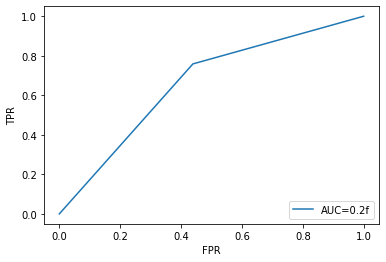

0.6599204289915239

In [185]:
#모델 성능 평가: precision, Recall, F1 Score, ROC Curve, AUC
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,auc
# roc curve 그리기, label에 auc표시(소수점 2자리)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

# save auc 
model_auc.append(roc_auc)

plt.plot(fpr, tpr, label ="AUC=0.2f"% roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

roc_auc 

In [92]:
roc_auc

0.7839241582986177

In [107]:
#precision, recall score
model_precision.append(precision_score(Y_test,y_pred))
model_recall.append(recall_score(Y_test, y_pred))

#f1 score
model_f1_score.append(f1_score(Y_test, y_pred))

In [84]:
model_precision

[0.9271936973648465]

#### RandomForest

In [182]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

pipe_model_rf = make_pipeline(preprocessing_pipe, 
                                 ADASYN(), 
                                 RandomForestClassifier(random_state = 1234,
                                                    criterion = 'entropy',
                                                    max_depth = 10, 
                                                    max_features = None,
                                                    min_samples_leaf = 6,
                                                    min_samples_split = 40))
pipe_model_rf.fit(X_train, Y_train)
y_pred = pipe_model_rf.predict(X_test) 

print('Accuracy on training Set : {:.4f}'.format(pipe_model_rf.score(X_train, Y_train)))

# train 정확도
train_accuracy.append(pipe_model_rf.score(X_train, Y_train))

print('Accuracy on test Set : {:.4f}'.format(pipe_model_rf.score(X_test, Y_test)))

# test 정확도
test_accuracy.append(pipe_model_rf.score(X_test, Y_test))

# confusion matrix
print('Confusion Matrix : \n {}'.format(confusion_matrix(Y_test, y_pred)))

# 목표변수의 불균형 : f1score로 모델 평가
print(classification_report(Y_test, y_pred, digits = 4))

Accuracy on training Set : 0.8012
Accuracy on test Set : 0.7175
Confusion Matrix : 
 [[ 48  34]
 [ 29 112]]
              precision    recall  f1-score   support

           0     0.6234    0.5854    0.6038        82
           1     0.7671    0.7943    0.7805       141

    accuracy                         0.7175       223
   macro avg     0.6952    0.6898    0.6921       223
weighted avg     0.7143    0.7175    0.7155       223



In [163]:
roc = roc_auc_score(Y_test, pipe_model_et.predict_proba(X_test)[:,1])
roc

0.8761970229828413

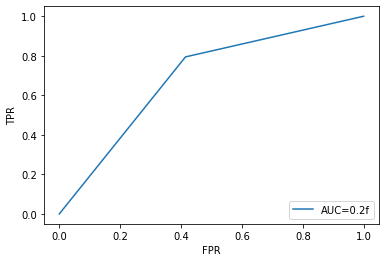

0.6898460473966443

In [183]:
#모델 성능 평가: precision, Recall, F1 Score, ROC Curve, AUC
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,auc
# roc curve 그리기, label에 auc표시(소수점 2자리)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

# save auc 
model_auc.append(roc_auc)

plt.plot(fpr, tpr, label ="AUC=0.2f"% roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

roc_auc

In [110]:
auc(fpr, tpr)

0.7143912629934098

In [57]:
pipe_model_rf.predict_proba(X_test)[:,1]

array([1.        , 0.97498071, 0.88399118, ..., 0.2622021 , 0.99226503,
       1.        ])

#### 모델 저장 및 불러오기

In [58]:
import pickle
# 모델 저장하기
with open('model_rf.sav','wb') as lf:
    pickle.dump(pipe_model_rf, lf)

In [ ]:
# 모델 불러오기 
with open('mode_rf.save', 'rb') as lf:
    data = pickle.load(lf)

In [111]:
#precision, recall score
model_precision.append(precision_score(Y_test,y_pred))
model_recall.append(recall_score(Y_test, y_pred))

#f1 score
model_f1_score.append(f1_score(Y_test, y_pred))

#### XGBoost

In [176]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

pipe_model_xg = make_pipeline(preprocessing_pipe, 
                                 ADASYN(), 
                                 XGBClassifier(random_state = 1234, learning_rate = 0.1, max_depth = 4, n_estimators = 100))
                                               
                                               
                                              #  learning_rate = 0.1, max_depth = 8, 
                                              #  min_child_weight = 10, n_estimators = 110))

pipe_model_xg.fit(X_train, Y_train)
y_pred = pipe_model_xg.predict(X_test) 



print('Accuracy on training Set : {:.4f}'.format(pipe_model_xg.score(X_train, Y_train)))

# train 정확도
train_accuracy.append(pipe_model_xg.score(X_train, Y_train))


print('Accuracy on test Set : {:.4f}'.format(pipe_model_xg.score(X_test, Y_test)))

# test 정확도
test_accuracy.append(pipe_model_xg.score(X_test, Y_test))

# confusion matrix
print('Confusion Matrix : \n {}'.format(confusion_matrix(Y_test, y_pred)))

# 목표변수의 불균형 : f1score로 모델 평가
print(classification_report(Y_test, y_pred, digits = 4))

Accuracy on training Set : 0.9103
Accuracy on test Set : 0.7309
Confusion Matrix : 
 [[ 45  37]
 [ 23 118]]
              precision    recall  f1-score   support

           0     0.6618    0.5488    0.6000        82
           1     0.7613    0.8369    0.7973       141

    accuracy                         0.7309       223
   macro avg     0.7115    0.6928    0.6986       223
weighted avg     0.7247    0.7309    0.7247       223



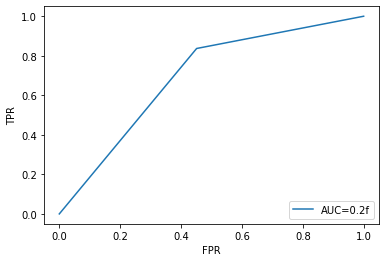

0.6928299602144958

In [177]:
#모델 성능 평가: precision, Recall, F1 Score, ROC Curve, AUC
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,auc
# roc curve 그리기, label에 auc표시(소수점 2자리)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

# save auc 
model_auc.append(roc_auc)

plt.plot(fpr, tpr, label ="AUC=0.2f"% roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()
roc_auc

In [95]:
roc_auc 

0.7196233222639616

In [114]:
#precision, recall score
model_precision.append(precision_score(Y_test,y_pred))
model_recall.append(recall_score(Y_test, y_pred))

#f1 score
model_f1_score.append(f1_score(Y_test, y_pred))

#### CatBoost

In [178]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

pipe_model_cb = make_pipeline(preprocessing_pipe, 
                                 ADASYN(), 
                                 CatBoostClassifier(random_state = 1234,
                                                    auto_class_weights = 'Balanced',
                                                    bootstrap_type = 'MVS', 
                                                    iterations = 1000, 
                                                    learning_rate = 0.05,
                                                    min_data_in_leaf = 6 ))
pipe_model_cb.fit(X_train, Y_train)
y_pred = pipe_model_cb.predict(X_test) 

# print('Accuracy on training Set : {:.4f}'.format(pipe_model_cb.score(X_train, Y_train)))

# train 정확도
train_accuracy.append(pipe_model_cb.score(X_train, Y_train))

print('Accuracy on test Set : {:.4f}'.format(pipe_model_cb.score(X_test, Y_test)))

# test 정확도
test_accuracy.append(pipe_model_cb.score(X_test, Y_test))

# confusion matrix
print('Confusion Matrix : \n {}'.format(confusion_matrix(Y_test, y_pred)))

# 목표변수의 불균형 : f1score로 모델 평가
print(classification_report(Y_test, y_pred, digits = 4))

0:	learn: 0.6720930	total: 4.12ms	remaining: 4.11s
1:	learn: 0.6524736	total: 6.24ms	remaining: 3.12s
2:	learn: 0.6359641	total: 8.31ms	remaining: 2.76s
3:	learn: 0.6215377	total: 10.5ms	remaining: 2.61s
4:	learn: 0.6056125	total: 13ms	remaining: 2.58s
5:	learn: 0.5919927	total: 15.7ms	remaining: 2.6s
6:	learn: 0.5818754	total: 17.9ms	remaining: 2.54s
7:	learn: 0.5725330	total: 20.1ms	remaining: 2.49s
8:	learn: 0.5625610	total: 22.5ms	remaining: 2.48s
9:	learn: 0.5536424	total: 25.8ms	remaining: 2.55s
10:	learn: 0.5446692	total: 28.8ms	remaining: 2.59s
11:	learn: 0.5365969	total: 35.2ms	remaining: 2.9s
12:	learn: 0.5321290	total: 41.7ms	remaining: 3.17s
13:	learn: 0.5238948	total: 48ms	remaining: 3.38s
14:	learn: 0.5166117	total: 54.6ms	remaining: 3.59s
15:	learn: 0.5100451	total: 60.9ms	remaining: 3.75s
16:	learn: 0.5053180	total: 67.3ms	remaining: 3.89s
17:	learn: 0.4988809	total: 73.7ms	remaining: 4.02s
18:	learn: 0.4926017	total: 80.1ms	remaining: 4.13s
19:	learn: 0.4881121	total: 

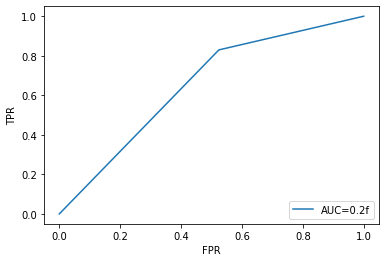

0.6526984950700571

In [179]:
#모델 성능 평가: precision, Recall, F1 Score, ROC Curve, AUC
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,auc
# roc curve 그리기, label에 auc표시(소수점 2자리)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

# save auc 
model_auc.append(roc_auc)

plt.plot(fpr, tpr, label ="AUC=0.2f"% roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()
roc_auc

In [117]:
#precision, recall score
model_precision.append(precision_score(Y_test,y_pred))
model_recall.append(recall_score(Y_test, y_pred))

#f1 score
model_f1_score.append(f1_score(Y_test, y_pred))

#### LGBM

In [180]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

pipe_model_lg = make_pipeline(preprocessing_pipe, 
                                 ADASYN(), 
                                 LGBMClassifier(random_state = 1234,
                                               learning_rate = 0.1, 
                                               min_child_samples = 5, 
                                               n_estimators = 110, 
                                               num_leaves = 60, 
                                               reg_alpha = 0.05))
pipe_model_lg.fit(X_train, Y_train)
y_pred = pipe_model_lg.predict(X_test) 

print('Accuracy on training Set : {:.4f}'.format(pipe_model_lg.score(X_train, Y_train)))

# train 정확도
train_accuracy.append(pipe_model_lg.score(X_train, Y_train))

print('Accuracy on test Set : {:.4f}'.format(pipe_model_lg.score(X_test, Y_test)))

# test 정확도
test_accuracy.append(pipe_model_lg.score(X_test, Y_test))

# confusion matrix
print('Confusion Matrix : \n {}'.format(confusion_matrix(Y_test, y_pred)))

# 목표변수의 불균형 : f1score로 모델 평가
print(classification_report(Y_test, y_pred, digits = 4))

Accuracy on training Set : 1.0000
Accuracy on test Set : 0.6996
Confusion Matrix : 
 [[ 41  41]
 [ 26 115]]
              precision    recall  f1-score   support

           0     0.6119    0.5000    0.5503        82
           1     0.7372    0.8156    0.7744       141

    accuracy                         0.6996       223
   macro avg     0.6746    0.6578    0.6624       223
weighted avg     0.6911    0.6996    0.6920       223



In [ ]:
#precision, recall score
model_precision.append(precision_score(Y_test,y_pred))
model_recall.append(recall_score(Y_test, y_pred))

#f1 score
model_f1_score.append(f1_score(Y_test, y_pred))

In [128]:
precision_score(Y_test,y_pred)

0.9298597194388778

In [169]:
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(Y_test, pipe_model_et.predict_proba(X_test)[:,1])
roc

0.8761970229828413

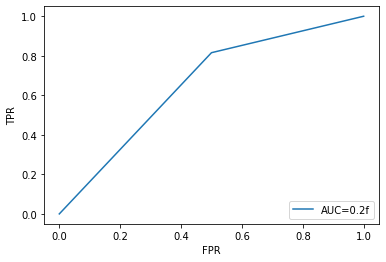

0.6578014184397163

In [181]:
#모델 성능 평가: precision, Recall, F1 Score, ROC Curve, AUC
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,auc
# roc curve 그리기, label에 auc표시(소수점 2자리)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

# save auc 
model_auc.append(roc_auc)

plt.plot(fpr, tpr, label ="AUC=0.2f"% roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()
roc_auc

In [120]:
#precision, recall score
model_precision.append(precision_score(Y_test,y_pred))
model_recall.append(recall_score(Y_test, y_pred))

#f1 score
model_f1_score.append(f1_score(Y_test, y_pred))

In [124]:
model_auc[0] = 0.7839

In [126]:
model_auc.insert(1,0.7144)

In [123]:
test_accuracy

[0.849375, 0.899375, 0.89625, 0.90125, 0.906875]

In [127]:
#모델별 평가 결과
df_eval = pd.DataFrame(index=model)
df_eval["TrainAccuracy"] = train_accuracy 
df_eval["TestAccuracy"] = test_accuracy
df_eval["AUC"] = model_auc
df_eval["Precision"] = model_precision;
df_eval["Recall"] = model_recall
df_eval["F1Score"] = model_f1_score
df_eval.round(4)

,TrainAccuracy,TestAccuracy,AUC,Precision,Recall,F1Score
ExtraTrees,0.8473,0.8494,0.7839,0.9761,0.8531,0.9104
RandomForest,0.9108,0.8994,0.7144,0.9412,0.9471,0.9441
XGBoost,0.9141,0.8962,0.7018,0.9385,0.9464,0.9424
CatBoost,0.9844,0.9012,0.6479,0.9266,0.9666,0.9461
LGBM,0.9958,0.9069,0.6646,0.9299,0.9694,0.9492


# STACKING

In [ ]:
# 개별 모델 정의
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier()
ab_clf = AdaBoostClassifier()
dt_clf = DecisionTreeClassifier()
# 최종 메타 모델 정의
lr_final = LogisticRegression(C=10)

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')

def get_stacking_datasets(model, x_train_n, y_train_n, x_test_n, n_folds):
    # CV하기 위해 K-fold 설정
    kf = KFold(n_splits=n_folds, shuffle=False)
    
    # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
    train_fold_pred = np.zeros((x_train_n.shape[0], 1)) # 2차원으로
    test_pred = np.zeros((x_test_n.shape[0], n_folds))
    print(model.__class__.__name__, '모델 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(kf.split(x_train_n)):
        # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터 셋 추출
        print(f" Fold 횟수 : {folder_counter+1}")
        x_tr = x_train_n[train_idx]
        y_tr = y_train_n[train_idx]
        x_te = x_train_n[valid_idx]
        
        # 개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
        model.fit(x_tr, y_tr)
        train_fold_pred[valid_idx, :] = model.predict(x_te).reshape(-1,1)
        # 개별 모델이 원본 데이터셋의 검증 데이터셋을 기반으로 예측 결과값 반환 후 최종 메타모델이 검증할 데이터셋에 첨가
        test_pred[:, folder_counter] = model.predict(x_test_n)
    
    # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸어주기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

knn_train, knn_test = get_stacking_datasets(knn_clf, x_train, y_train, x_test, 5)
rf_train, rf_test = get_stacking_datasets(rf_clf, x_train, y_train, x_test, 5)
ab_train, ab_test = get_stacking_datasets(ab_clf, x_train, y_train, x_test, 5)
dt_train, dt_test = get_stacking_datasets(dt_clf, x_train, y_train, x_test, 5)

## Feature Importances

In [ ]:
df_importances= pd.DataFrame()
df_importances['Importance'] = pipe_model_lg['lgbmclassifier'].feature_importances_

total_list = numeric_list
encode_list = pipe_model_lg.named_steps['columntransformer'].named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names(input_features=category_list)
total_list.extend(encode_list)
df_importances['Columns'] = total_list

In [ ]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importances.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importances))
plt.figure(figsize=(15, 10))
plt.barh(y=coordinates, width=df_importances["Importance"])
plt.yticks(coordinates, df_importances["Columns"])
plt.xlabel("Feature Importance")
plt.ylabel("Features")

In [ ]:
import matplotlib
matplotlib.rc('font', family = 'NanumGothic')


In [ ]:
#모델별 평가 지표 확인
df_eval.plot.bar(rot=0,figsize=(10,6))
plt.legend(loc="lower right")
plt.grid(axis="y")